In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/Chicken_Disease_Detection/chicken_dataset.zip'

extract_path = '/content/drive/MyDrive/Chicken_Disease_Detection/chicken_dataset_folder'

os.makedirs(extract_path, exist_ok=True)

try:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
  print(f"Successfully extracted '{zip_file_path}' to '{extract_path}'")
except FileNotFoundError:
  print(f"Error: File '{zip_file_path}' not found.")
except zipfile.BadZipFile:
  print(f"Error: Invalid zip file '{zip_file_path}'.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Successfully extracted '/content/drive/MyDrive/Chicken_Disease_Detection/chicken_dataset.zip' to '/content/drive/MyDrive/Chicken_Disease_Detection/chicken_dataset_folder'


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2

In [ ]:
sdir=r'/content/drive/MyDrive/Chicken_Disease_Detection-20241126T170359Z-001/Chicken_Disease_Detection/chicken_dataset_folder/Train'
csvpath=r'/content/drive/MyDrive/Chicken_Disease_Detection-20241126T170359Z-001/Chicken_Disease_Detection/chicken_dataset_folder/train_data.csv'
df=pd.read_csv(csvpath)

In [ ]:
df.head()

images               label
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease

In [ ]:
df.columns=['filepaths', 'labels' ]
df.head()

filepaths              labels
0  salmo.1558.jpg          Salmonella
1  cocci.1866.jpg         Coccidiosis
2   cocci.171.jpg         Coccidiosis
3  salmo.1484.jpg          Salmonella
4     ncd.100.jpg  New Castle Disease

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8067 entries, 0 to 8066
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  8067 non-null   object
 1   labels     8067 non-null   object
dtypes: object(2)
memory usage: 126.2+ KB


In [ ]:
df.describe(include="object")

filepaths      labels
count             8067        8067
unique            8067           4
top     salmo.1558.jpg  Salmonella
freq                 1        2625

In [ ]:
df['filepaths']=df['filepaths'].apply(lambda x: os.path.join(sdir,x))
df.head()

filepaths              labels
0  /content/drive/MyDrive/Chicken_Disease_Detecti...          Salmonella
1  /content/drive/MyDrive/Chicken_Disease_Detecti...         Coccidiosis
2  /content/drive/MyDrive/Chicken_Disease_Detecti...         Coccidiosis
3  /content/drive/MyDrive/Chicken_Disease_Detecti...          Salmonella
4  /content/drive/MyDrive/Chicken_Disease_Detecti...  New Castle Disease

In [ ]:
df.isna().sum()

filepaths    0
labels       0
dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
img = df.iloc[10,0]
img

'/content/drive/MyDrive/Chicken_Disease_Detection-20241126T170359Z-001/Chicken_Disease_Detection/chicken_dataset_folder/Train/cocci.686.jpg'

In [ ]:
image = cv2.imread(img)
if image is None:
    print(f"Failed to load image from path: {img}")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


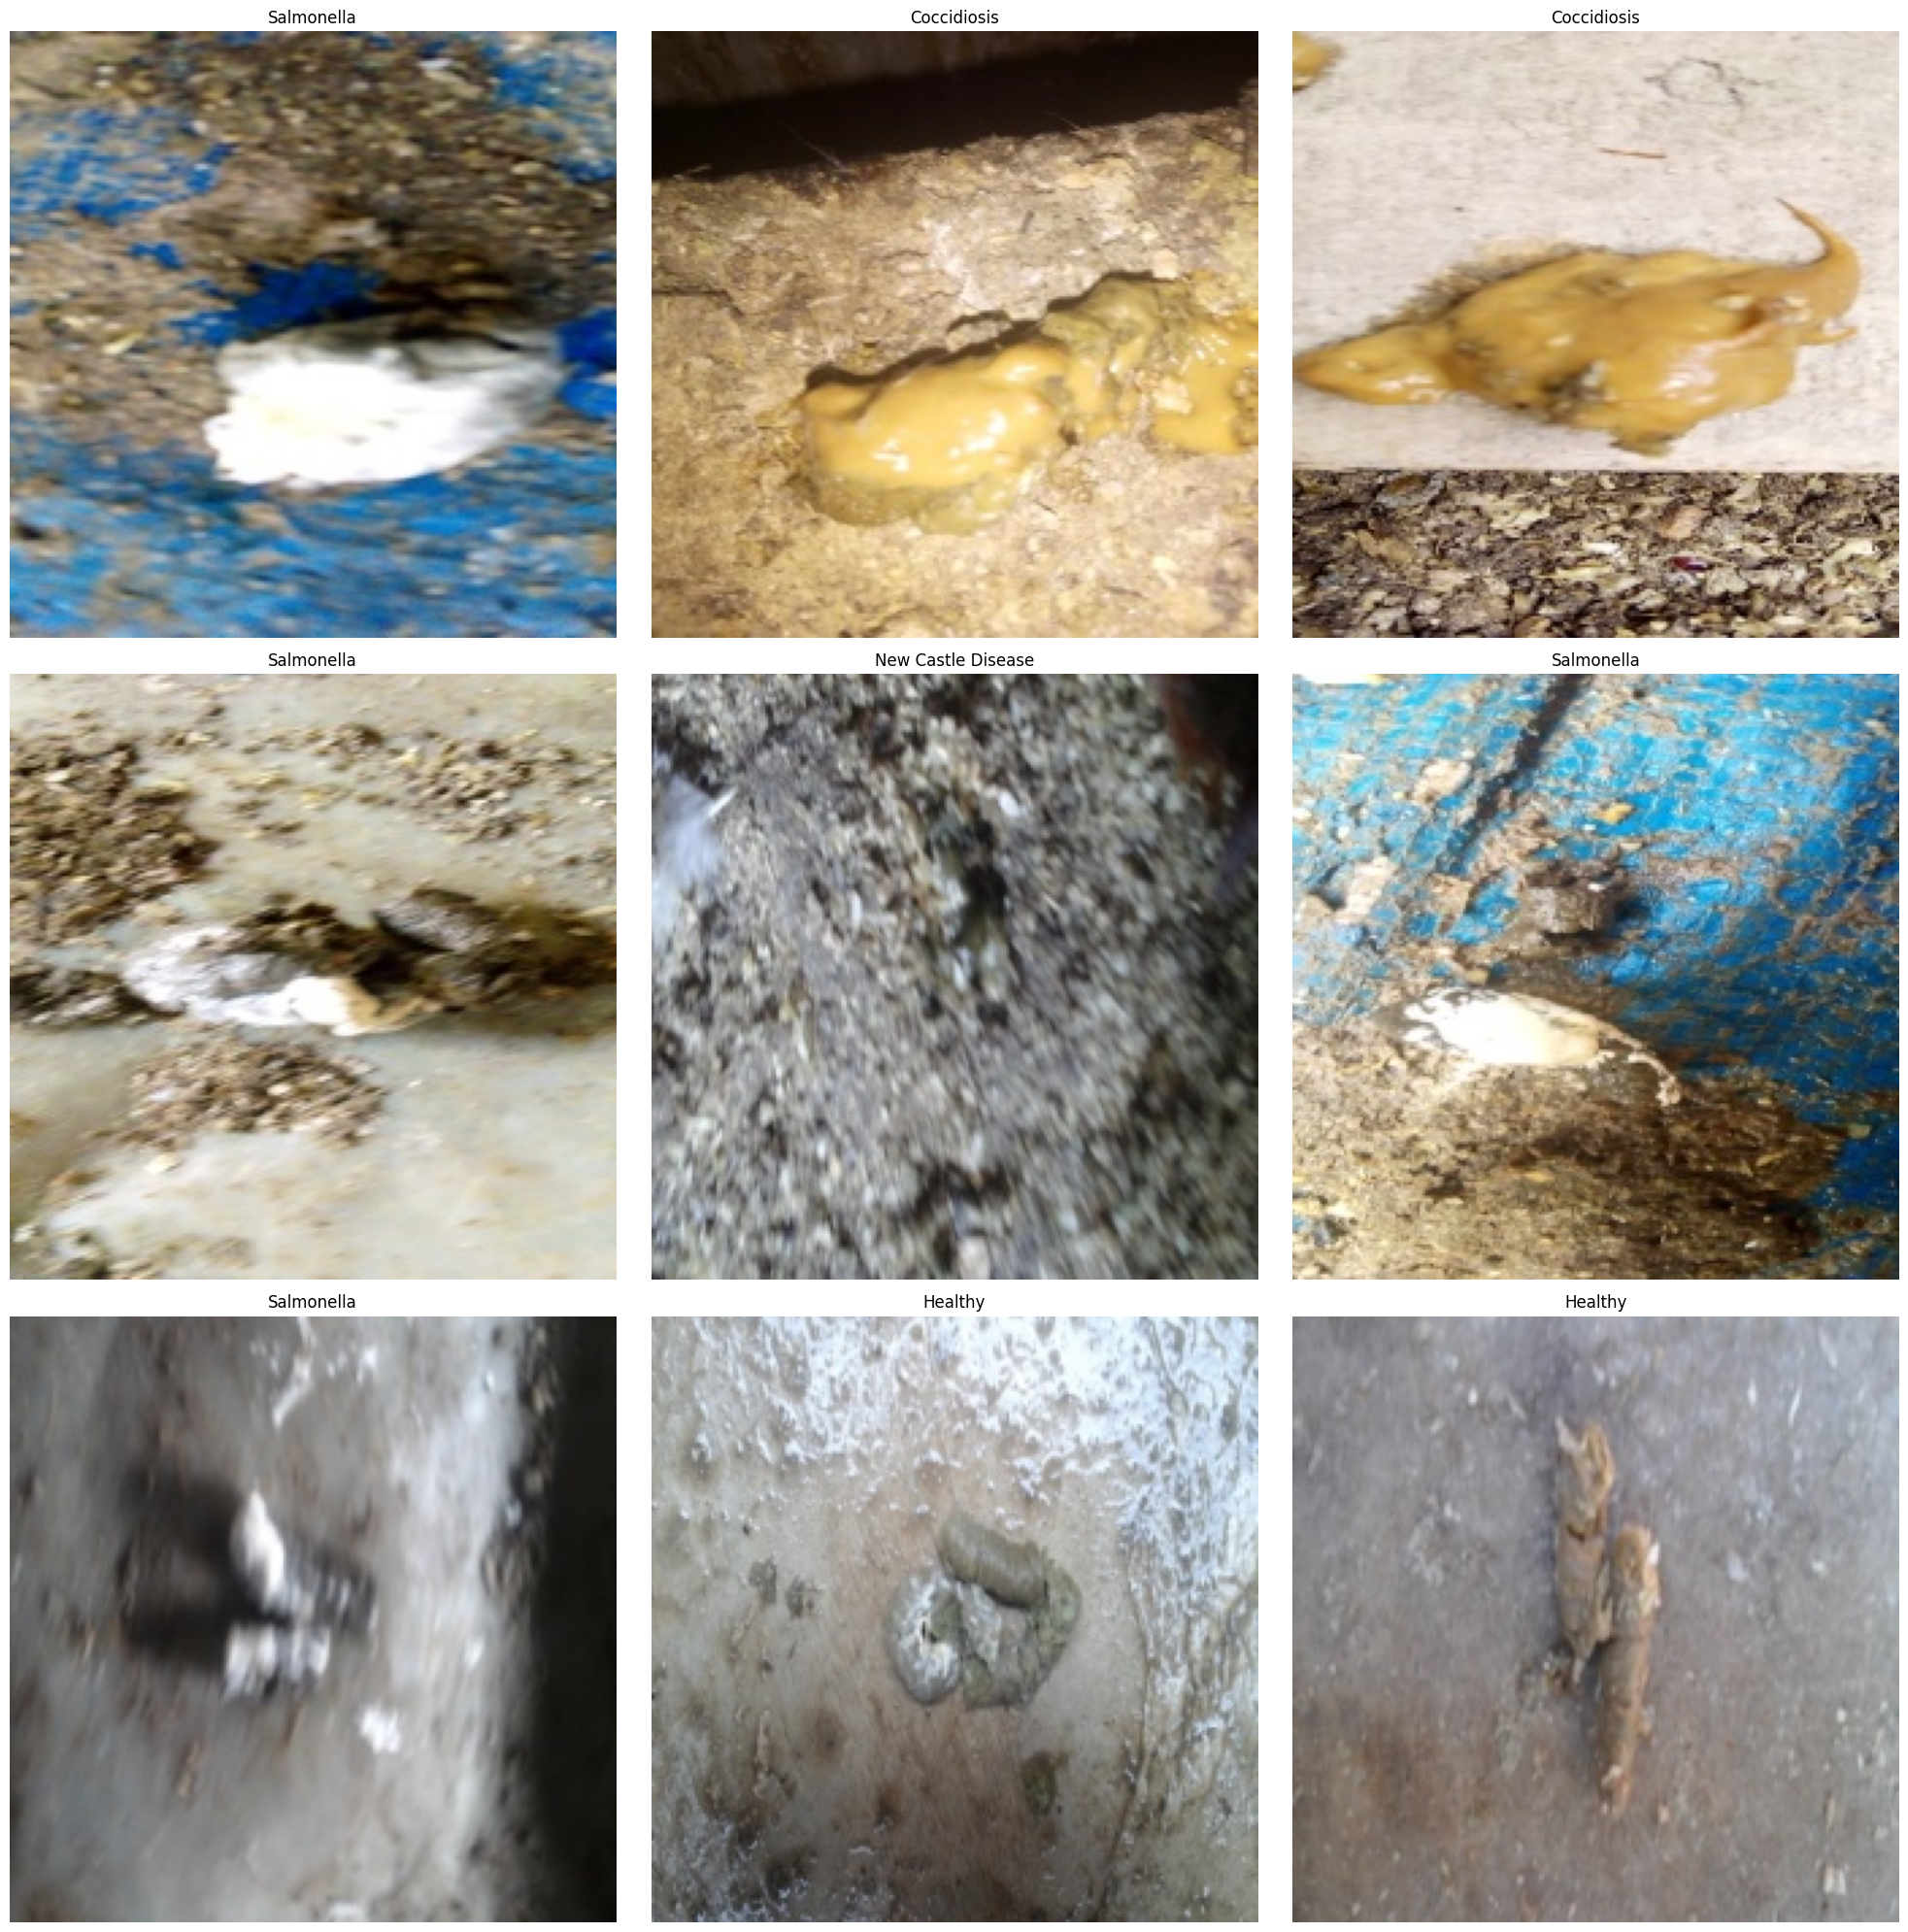

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
ax = ax.ravel()

for idx in range(min(9, len(df))):
    img = cv2.imread(df['filepaths'][idx])

    if img is not None:
        img = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[idx].imshow(img_rgb)

        label = df['labels'][idx]

        ax[idx].title.set_text(label)
        ax[idx].axis('off')
    else:
        print(f"Image at index {idx} not found or couldn't be loaded.")

plt.tight_layout()
plt.show()

In [ ]:
image.shape

(224, 224, 3)

In [ ]:
df['labels'].unique()

array(['Salmonella', 'Coccidiosis', 'New Castle Disease', 'Healthy'],
      dtype=object)

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def transform_data(df, image_size=(180, 180)):

    images = []
    labels = []

    for _, row in df.iterrows():
        img = cv2.imread(row['filepaths'])
        if img is not None:
            try:
                img = cv2.resize(img, image_size)
                img = img / 255.0
                images.append(img)
                labels.append(row['labels'])
            except Exception as e:
                print(f"Error processing image {row['filepaths']}: {e}")
        else:
            print(f"Warning: Image {row['filepaths']} could not be loaded.")


    X = np.array(images, dtype=np.float32)


    lb = LabelEncoder()
    y = lb.fit_transform(labels)
    y = to_categorical(y, num_classes=len(lb.classes_))

    print(f"Found {len(lb.classes_)} unique classes: {lb.classes_}")

    return X, y


def load_data(X, y):
    """
    Load the preprocessed data for training.

    Parameters:
        X (ndarray): Image data.
        y (ndarray): Labels.

    Returns:
        X, y: Same as input for compatibility.
    """
    return X, y

try:
    X, y = transform_data(df, image_size=(128, 128))
    X_train, y_train = load_data(X, y)
    print(f"Data shape: {X_train.shape}, Labels shape: {y_train.shape}")
except Exception as e:
    print(f"Error during data processing: {e}")


In [ ]:
y

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, temp_df, train_labels, temp_labels = train_test_split(
    X, y, train_size=0.8, shuffle=True, random_state=123, stratify=y
)

val_df, test_df, val_labels, test_labels = train_test_split(
    temp_df, temp_labels, test_size=0.5, shuffle=True, random_state=123, stratify=temp_labels
)

print("Train set:", train_df.shape, train_labels.shape)
print("Validation set:", val_df.shape, val_labels.shape)
print("Test set:", test_df.shape, test_labels.shape)

Train set: (6453, 128, 128, 3) (6453, 4)
Validation set: (807, 128, 128, 3) (807, 4)
Test set: (807, 128, 128, 3) (807, 4)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [ ]:
model.build(input_shape=(None, 128, 128, 3))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 4, 4, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,944,827 (140.93 MB)

 Trainable params: 36,771,572 (140.27 MB)

 Non-trainable params: 173,255 (676.78 KB)

In [ ]:
history = model.fit(
    train_df, train_labels,
    validation_data=(val_df, val_labels),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 391s 975ms/step - accuracy: 0.6661 - loss: 0.8005 - val_accuracy: 0.0706 - val_loss: 2.9275
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 60s 200ms/step - accuracy: 0.9405 - loss: 0.1801 - val_accuracy: 0.3086 - val_loss: 1.5826
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.9714 - loss: 0.0934 - val_accuracy: 0.3420 - val_loss: 2.2815
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.9810 - loss: 0.0618 - val_accuracy: 0.8079 - val_loss: 0.7178
Epoch 5/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.9865 - loss: 0.0438 - val_accuracy: 0.9232 - val_loss: 0.2794
Epoch 6/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.9861 - loss: 0.0378 - val_accuracy: 0.9331 - val_loss: 0.2584
Epoch 7/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.9890 - loss: 0.0365 - val_accuracy: 0.9331 - val_loss: 0.2564
Epoch 8/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 80s 199ms/step - accuracy: 0.9901 - loss: 

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9594 - loss: 0.1697
Test Loss: 0.1705, Test Accuracy: 0.9628


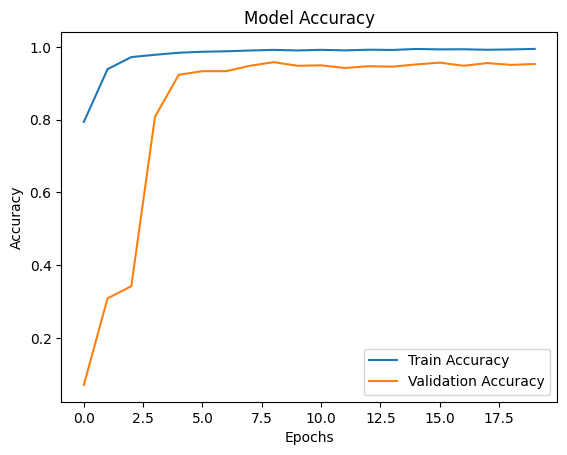

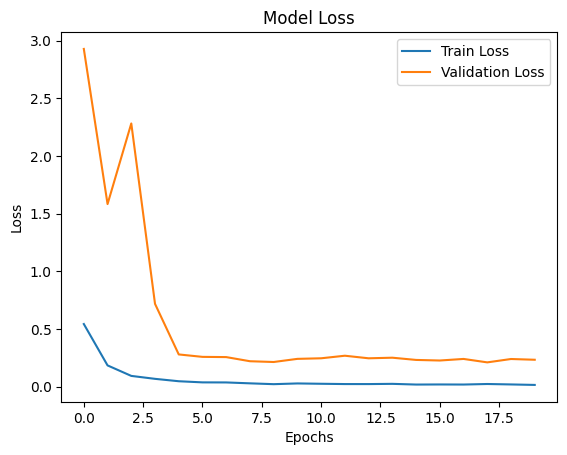

In [ ]:
test_loss, test_accuracy = model.evaluate(test_df, test_labels)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Visualize training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_df, test_labels, verbose=1)

print("Test Accuracy:", test_accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9594 - loss: 0.1697
Test Accuracy: 0.9628252983093262


26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step


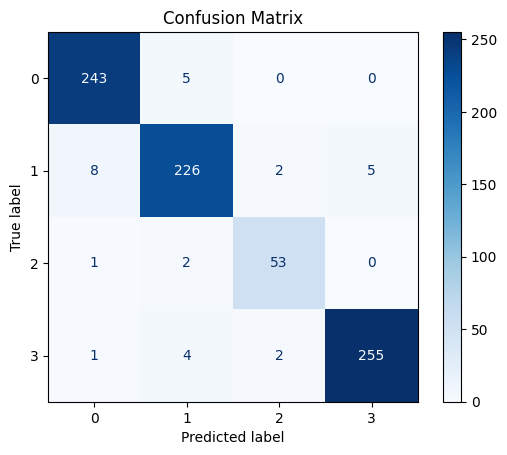

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

predictions = model.predict(test_df)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

lb = LabelEncoder()

encoded_labels = lb.fit_transform(df['labels'])

print("Label Encodings:")
for index, class_label in enumerate(lb.classes_):
    print(f"{index} -> {class_label}")

Label Encodings:
0 -> Coccidiosis
1 -> Healthy
2 -> New Castle Disease
3 -> Salmonella


## **Prediction**

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

predictions = model.predict(test_df)

encoded_predictions = np.argmax(predictions, axis=1)

lb = LabelEncoder()
lb.classes_ = np.array(['Coccidiosis', 'Healthy', 'New Castle Disease', 'Salmonella'])
decoded_predictions = lb.inverse_transform(encoded_predictions)
decoded_real_labels = lb.inverse_transform(np.argmax(test_labels, axis=1))

for i in range(9):
    print(f"Predicted: {decoded_predictions[i]}, Real: {decoded_real_labels[i]}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Predicted: Healthy, Real: Healthy
Predicted: Salmonella, Real: Salmonella
Predicted: Coccidiosis, Real: Coccidiosis
Predicted: Healthy, Real: Healthy
Predicted: New Castle Disease, Real: New Castle Disease
Predicted: Salmonella, Real: Salmonella
Predicted: Healthy, Real: Healthy
Predicted: New Castle Disease, Real: New Castle Disease
Predicted: Salmonella, Real: Salmonella
